# Example notebook for using `cpymad` and `MAD-X` for beam line design

In the following you find a demonstration on how to design a FODO beam line with `MAD-X`, using the `cpymad` library for the python API.

You may run this jupyter notebook through the binder service by https://mybinder.org/ .

Enjoy to the max! :-)

Nov 2021, Adrian Oeftiger

## Basic imports

In [1]:
import numpy as np

from cpymad.madx import Madx
from matplotlib import pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('ticks',
              {'grid.linestyle': 'none', 'axes.edgecolor': '0',
               'axes.linewidth': 1.2, 'legend.frameon': True,
               'xtick.direction': 'out', 'ytick.direction': 'out',
               'xtick.top': True, 'ytick.right': True,
              })

## Let's get going with `MAD-X`, launching an instance

In [2]:
madx = Madx(stdout=True)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2021.11.08 09:10:19      +
  ++++++++++++++++++++++++++++++++++++++++++++


## Some basic parameters for our FODO cell

In [3]:
circumference = 2 # [m]
harmonic = 2
Etot = 1 # [GeV]

Qx = 0.27
Qy = 0.23

## Define the FODO cell and the beam description in `MAD-X`

In [4]:
madx.input('''
kqd := -3.3 * 0.1;
kqf := 3.3 * 0.1;
v := 0;

qd: quadrupole, l = 0.05, k1 := kqd / 0.1; 
qf: quadrupole, l = 0.1, k1 := kqf / 0.1;
rf: rfcavity, volt := v, harmon = {1}, lag = 0;

fodo: sequence, l = {0};
qd, at = 0.025;
rf, at = {0} / 4.;
qf, at = {0} / 2.;
rf, at = {0} * 3 / 4.;
qd, at = {0} - 0.025;
endsequence;
'''.format(circumference, harmonic))

True

In [5]:
madx.command.beam(particle='proton', energy=str(Etot))

True

In [6]:
madx.use(sequence='fodo')

## Changing the quadrupole focusing strength to match the set tunes

In [7]:
madx.input(
'''match, sequence=fodo;
global, sequence=fodo, q1={Qx}, q2={Qy};
vary, name = kqd, step=0.0001;
vary, name = kqf, step=0.0001;
lmdif, tolerance=1e-20;
endmatch;
'''.format(Qx=Qx, Qy=Qy))

START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   4.34181647e-28





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqd                      -1.40187e+00 -3.30000e-01 -1.00000e+20  1.00000e+20
kqf                       1.52930e+00  3.30000e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   4.34181647e-28


True

## Let's check with the `twiss` command for the periodic solution

In [8]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                 2                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
              0.27      -0.9835360639        3.206778375                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0               0.23 

               dq2            betymax              dymax              dyrms 
     -0.8711697563        3.472173277                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

           synch_6            

## Plotting the $\beta_{x,y}$ functions

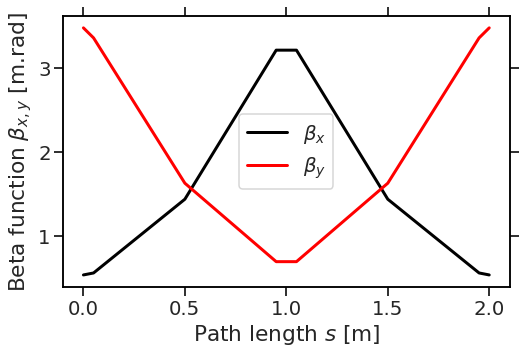

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m.rad]')
plt.legend();

## With a thin lattice and some markers we can improve the plotting resolution

In [10]:
assert madx.command.select(
    flag='MAKETHIN',
    class_='qd',
    slice_=8,
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='qf',
    slice_=16,
)

madx.command.makethin(
    makedipedge=False,
    style='simple', # more accurate alternative: 'teapot'
    sequence='fodo',
)

makethin: style chosen : simple
makethin: slicing sequence : fodo


True

In [11]:
madx.command.seqedit(sequence='fodo')
for s in np.linspace(start=0, stop=circumference, num=100, endpoint=False):
    madx.command.install(element='Marker', at=s)
madx.command.flatten()
madx.command.endedit()

++++++ info: seqedit - number of elements installed:  100
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [12]:
madx.use(sequence='fodo')

In [13]:
twiss = madx.twiss()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                 2                 -0    1.665334537e-15        24504692.41 

                q1                dq1            betxmax              dxmax 
      0.2700457087      -0.9838371709        3.331794009                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2300434147 

               dq2            betymax              dymax              dyrms 
      -0.871385249        3.471898141                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

           synch_6            

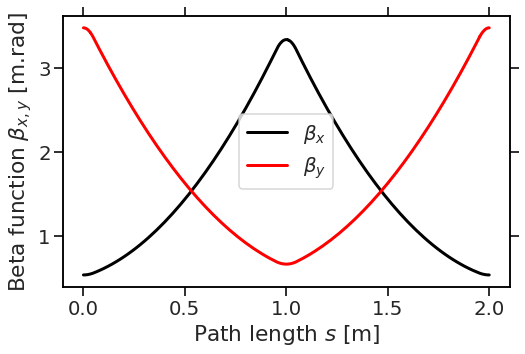

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
plt.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='red')
plt.xlabel('Path length $s$ [m]')
plt.ylabel(r'Beta function $\beta_{x,y}$ [m.rad]')
plt.legend();

## $\implies$ Beautiful... now go ahead and have fun designing your own accelerator!